In [1]:
import matplotlib.pyplot as plt

import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.print_version import show_versions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
show_versions()


INSTALLED VERSIONS
------------------
Python: 3.10.13.final.0
OS: Darwin 23.2.0 Darwin Kernel Version 23.2.0: Wed Nov 15 21:53:18 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T6000 arm64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.14.1 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/statsmodels)

Required Dependencies

cython: 3.0.8 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/Cython)
numpy: 1.26.3 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/numpy)
scipy: 1.11.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/scipy)
pandas: 2.1.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pandas)
    dateutil: 2.8.2 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/dateutil)
patsy: 0.5.6 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pats

In [3]:
returns = pd.read_csv('returns.txt', header=None).squeeze()
returns.index = pd.date_range('1/1/2000', periods=returns.values.shape[0], freq='D')
returns.name = 'returns'

returns.head()

2000-01-01   -0.000085
2000-01-02    0.000093
2000-01-03    0.000026
2000-01-04    0.000034
2000-01-05   -0.000077
Freq: D, Name: returns, dtype: float64

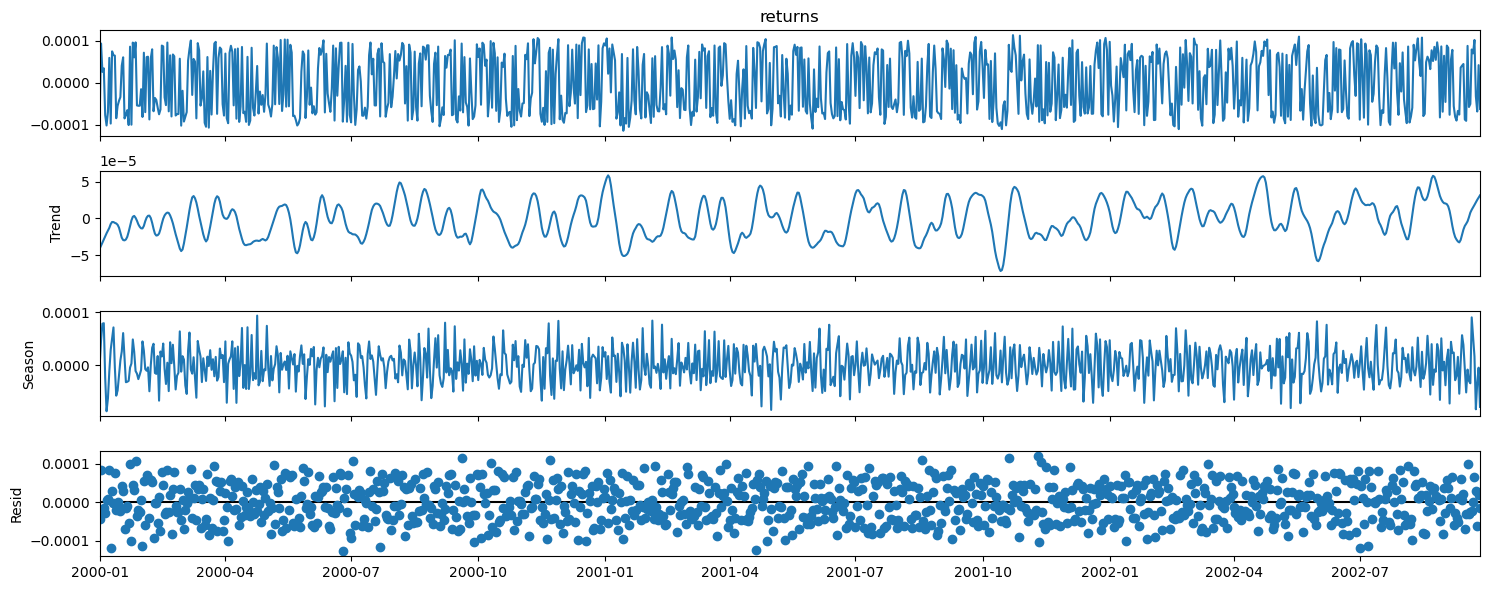

In [4]:
plt.rcParams['figure.figsize'] = (15, 6)

res = STL(returns).fit()
res.plot();

ADF Statistic: -29.524358
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


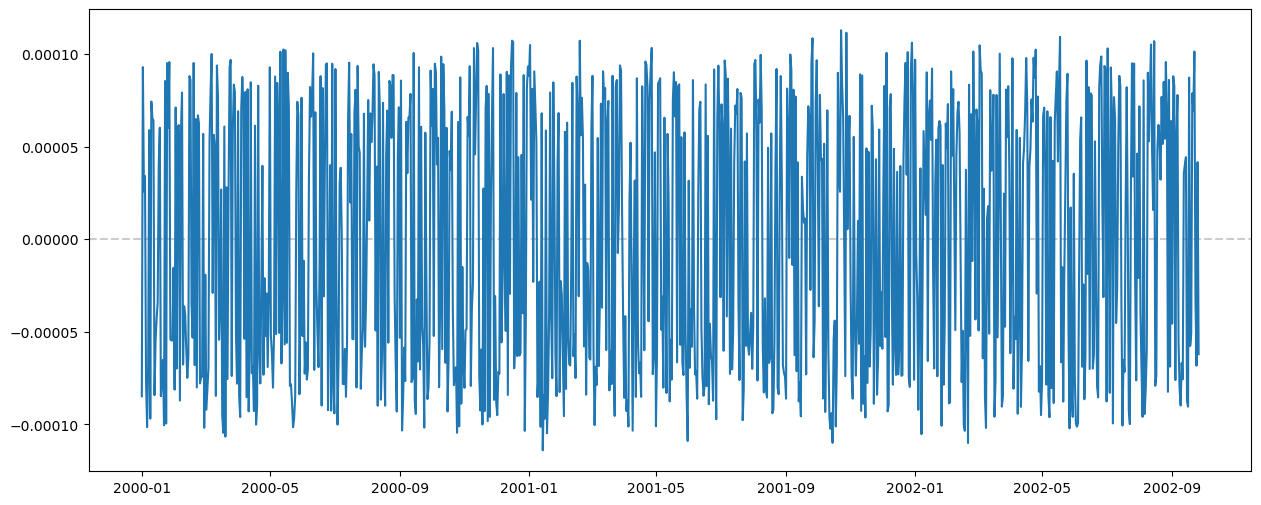

In [5]:
def adfuller_test_and_plot(series, first_100=True):
    len = 100 if first_100 else series.values.shape[0]
    slice = series[:len]

    adf = adfuller(slice)
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))

    plt.axhline(0, color='k', linestyle='--', alpha=0.2)
    plt.plot(slice)

adfuller_test_and_plot(returns, False)

ADF Statistic: -5.273241
p-value: 0.000006
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


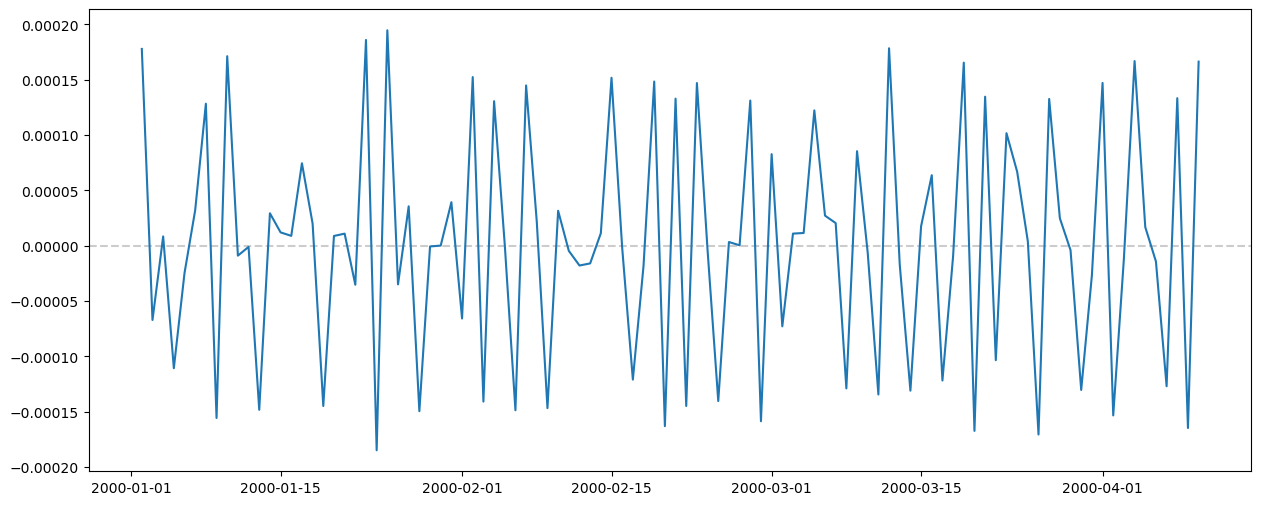

In [6]:
diff_returns = returns.diff().dropna()

adfuller_test_and_plot(diff_returns)

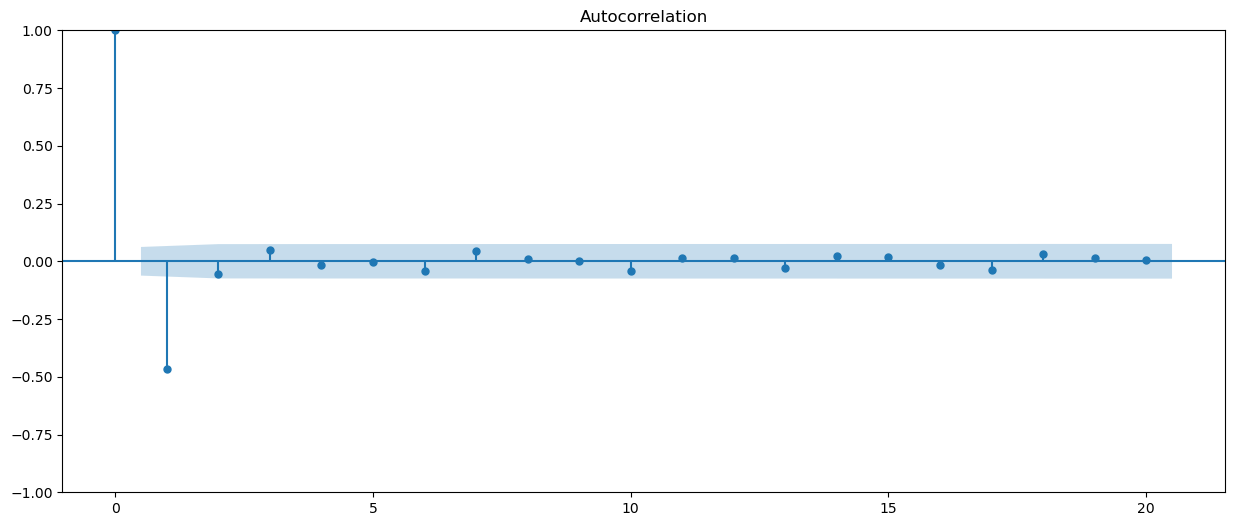

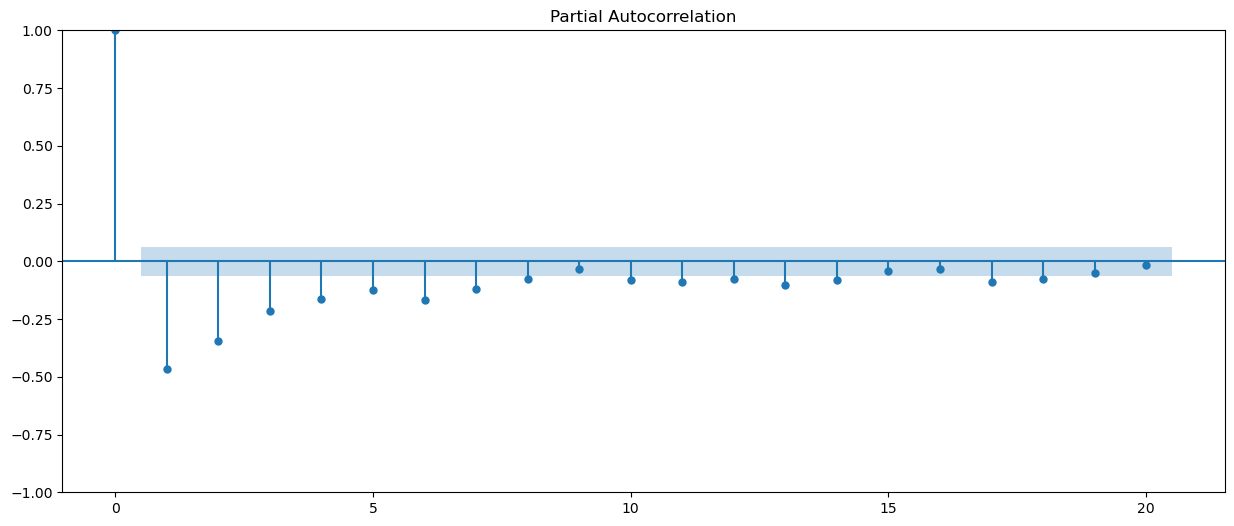

In [7]:
plot_acf(diff_returns, lags=20);
plot_pacf(diff_returns, lags=20);

In [8]:
import warnings

warnings.filterwarnings('ignore')

split_size = int(returns.size / 2)
train_data = returns[:split_size]
test_data = returns[split_size:]
returns_order = (20, 1, 1)

model = ARIMA(train_data, order=returns_order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                  500
Model:                ARIMA(20, 1, 1)   Log Likelihood                4014.953
Date:                Sat, 20 Jan 2024   AIC                          -7985.906
Time:                        18:24:15   BIC                          -7893.228
Sample:                    01-01-2000   HQIC                         -7949.536
                         - 05-14-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2526   2.08e-18  -1.21e+17      0.000      -0.253      -0.253
ar.L2         -0.3727   4.05e-19  -9.21e+17      0.000      -0.373      -0.373
ar.L3         -0.4813   1.56e-20  -3.08e+19      0.0

In [9]:
# rolling forecast origin
rolling_forecasts = test_data.copy()
for train_end in test_data.index:
    train_data = returns[:train_end]
    model = ARIMA(train_data, order=returns_order)
    model_fit = model.fit()
    prediction = model_fit.forecast()
    rolling_forecasts[train_end] = prediction

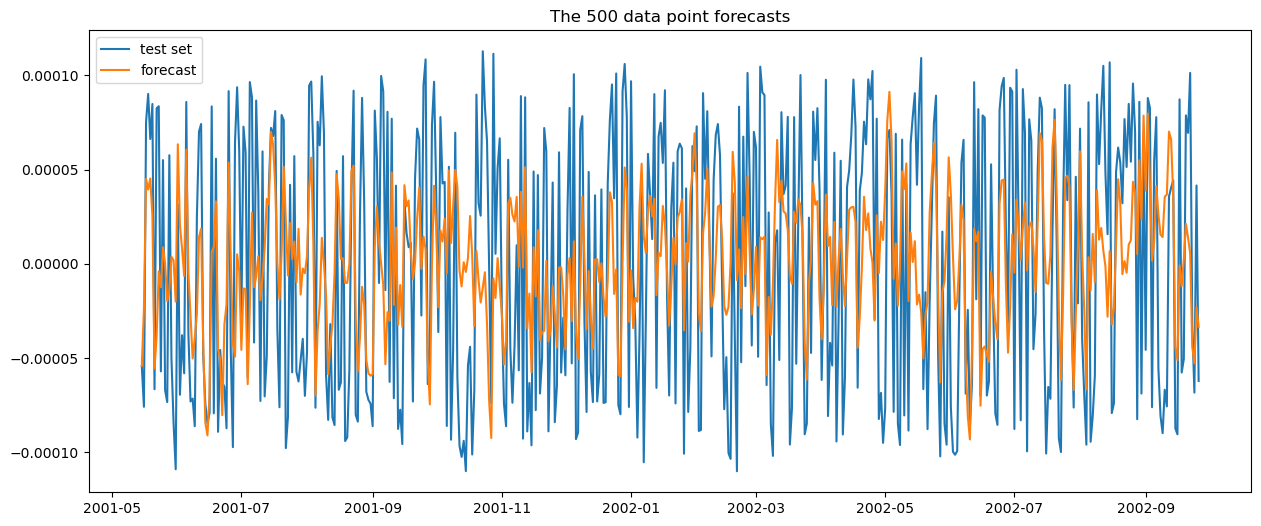

In [10]:
plt.plot(test_data, label='test set')
plt.plot(rolling_forecasts, label='forecast')
plt.title('The 500 data point forecasts')
plt.legend()

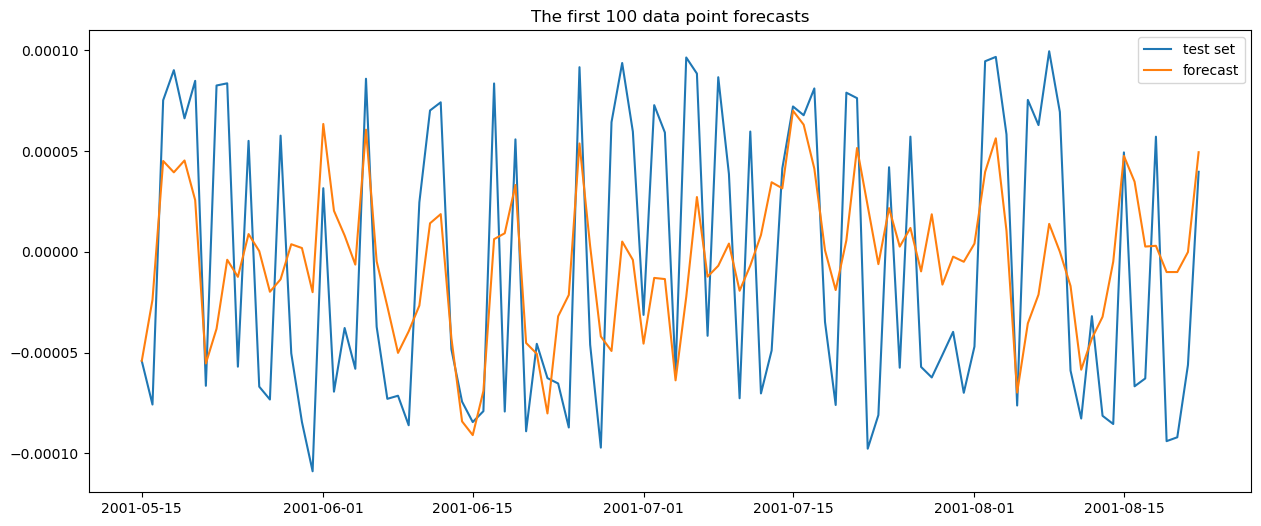

In [11]:
plt.plot(test_data[:100], label='test set')
plt.plot(rolling_forecasts[:100], label='forecast')
plt.title('The first 100 data point forecasts')
plt.legend()

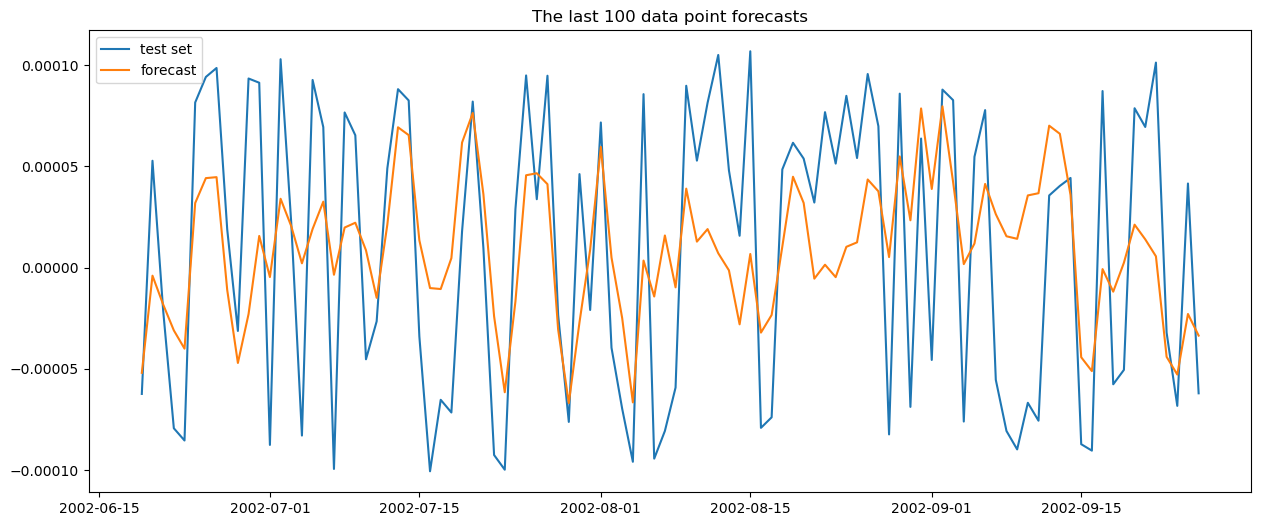

In [12]:
plt.plot(test_data[-100:], label='test set')
plt.plot(rolling_forecasts[-100:], label='forecast')
plt.title('The last 100 data point forecasts')
plt.legend()

In [13]:
from statsmodels.tools.eval_measures import mse

mse(rolling_forecasts, test_data)

3.475388867571033e-09